In [ ]:
# Objective: Objective of the project is to develop a model that predicts which previously purchased products will be in
# a user’s next order.  For this I choose Random Forest Classifier, AdaBoost Classifier (Adaptive Boosting) and LightGBM as
# a prediction models.

# Data Source:  Use open-sourced data from the Instacart Kaggle competition from 2017 for this project. 
# (Source: https://www.kaggle.com/competitions/instacart-market-basket-analysis/data)


In [ ]:
# pip install eli5
# !pip install wordcloud
# !pip install lightgbm

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize']=(25,15)
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from wordcloud import WordCloud
from IPython.display import display
import time
import eli5
from scipy.stats import randint 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, roc_auc_score, f1_score
import warnings
warnings.filterwarnings('ignore')

### Loading data

In [ ]:
# converting data types to lower byte sizes for more efficient memory use

aisles = pd.read_csv('aisles.csv', dtype={'aisle_id':'uint8',
                                          'aisle': str})
departments = pd.read_csv('departments.csv', dtype={'department_id':'uint8',
                                                    'department': str})
prior = pd.read_csv('order_products__prior.csv', dtype={'add_to_cart_order':'uint8',
                                                                   'reordered':'uint8',
                                                                   'order_id':np.uint32,
                                                                   'product_id':np.uint16})
train = pd.read_csv('order_products__train.csv', dtype={'add_to_cart_order':'uint8',
                                                                   'reordered':'uint8',
                                                                   'order_id':np.uint32,
                                                                   'product_id':np.uint16})
orders = pd.read_csv('orders.csv', dtype={'order_id':np.uint32,
                                          'user_id' :np.uint32,
                                          'order_number':'uint8',
                                          'order_hour_of_day':'uint8',
                                          'order_dow':'uint8',
                                          'days_since_prior_order':'float16'})
products = pd.read_csv('products.csv', dtype={'aisle_id':'uint8',
                                              'department_id':'uint8',
                                              'product_name': str,
                                              'product_id': np.uint16})

### Exploring the data

In [ ]:
display(aisles)
display(aisles.info())
display(aisles.isna().sum())

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    uint8 
 1   aisle     134 non-null    object
dtypes: object(1), uint8(1)
memory usage: 1.3+ KB


None

aisle_id    0
aisle       0
dtype: int64

In [ ]:
display(departments)
display(departments.info())
display(departments.isna().sum())

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     uint8 
 1   department     21 non-null     object
dtypes: object(1), uint8(1)
memory usage: 317.0+ bytes


None

department_id    0
department       0
dtype: int64

In [ ]:
display(prior)
display(prior.info())
display(prior.isna().sum())
display(prior['reordered'].value_counts())

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   order_id           uint32
 1   product_id         uint16
 2   add_to_cart_order  uint8 
 3   reordered          uint8 
dtypes: uint16(1), uint32(1), uint8(2)
memory usage: 247.5 MB


None

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

1    19126536
0    13307953
Name: reordered, dtype: int64

In [ ]:
display(train)
display(train.info())
display(train.isna().sum())

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   order_id           1384617 non-null  uint32
 1   product_id         1384617 non-null  uint16
 2   add_to_cart_order  1384617 non-null  uint8 
 3   reordered          1384617 non-null  uint8 
dtypes: uint16(1), uint32(1), uint8(2)
memory usage: 10.6 MB


None

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [ ]:
display(orders)
display(orders.info())
display(orders.isna().sum())

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                uint32 
 1   user_id                 uint32 
 2   eval_set                object 
 3   order_number            uint8  
 4   order_dow               uint8  
 5   order_hour_of_day       uint8  
 6   days_since_prior_order  float16
dtypes: float16(1), object(1), uint32(2), uint8(3)
memory usage: 68.5+ MB


None

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [ ]:
display(orders['eval_set'].value_counts())
display(orders['order_dow'].value_counts())
display(orders['order_hour_of_day'].value_counts())

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

0    600905
1    587478
2    467260
5    453368
6    448761
3    436972
4    426339
Name: order_dow, dtype: int64

10    288418
11    284728
15    283639
14    283042
13    277999
12    272841
16    272553
9     257812
17    228795
18    182912
8     178201
19    140569
20    104292
7      91868
21     78109
22     61468
23     40043
6      30529
0      22758
1      12398
5       9569
2       7539
4       5527
3       5474
Name: order_hour_of_day, dtype: int64

In [ ]:
display(products)
display(products.info())
display(products.isna().sum())

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  uint16
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  uint8 
 3   department_id  49688 non-null  uint8 
dtypes: object(1), uint16(1), uint8(2)
memory usage: 582.4+ KB


None

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

### Cleaning missing data

In [ ]:
# While exploring the data, there is NaN values in Orders

display(orders.isna().sum())

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [ ]:
# replace NaN by 0

orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0)
print(orders.isna().sum())

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64


In [ ]:
# Check any duplicate records

print('Duplicate rows in aisles: {}'.format(aisles.duplicated().any()))
print('Duplicate rows in departments: {}'.format(departments.duplicated().any()))
print('Duplicate rows in prior: {}'.format(prior.duplicated().any()))
print('Duplicate rows in train: {}'.format(train.duplicated().any()))
print('Duplicate rows in orders: {}'.format(orders.duplicated().any()))
print('Duplicate rows in products: {}'.format(products.duplicated().any()))

Duplicate rows in aisles: False
Duplicate rows in departments: False
Duplicate rows in prior: False
Duplicate rows in train: False
Duplicate rows in orders: False
Duplicate rows in products: False


### Merging dataframes

#### Order related data:

In [ ]:
# concatenate order_prod_prior and order_prod_train

order_prod = pd.concat([prior, train], ignore_index=True)

In [ ]:
print(prior.shape)
print(train.shape)
print(order_prod.shape)

(32434489, 4)
(1384617, 4)
(33819106, 4)


In [ ]:
# merge orders with order_prod

df_orders = pd.merge(orders, order_prod, on='order_id')

In [ ]:
print(df_orders.shape)
display(df_orders.head(15))

(33819106, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,0.0,196,1,0
1,2539329,1,prior,1,2,8,0.0,14084,2,0
2,2539329,1,prior,1,2,8,0.0,12427,3,0
3,2539329,1,prior,1,2,8,0.0,26088,4,0
4,2539329,1,prior,1,2,8,0.0,26405,5,0
5,2398795,1,prior,2,3,7,15.0,196,1,1
6,2398795,1,prior,2,3,7,15.0,10258,2,0
7,2398795,1,prior,2,3,7,15.0,12427,3,1
8,2398795,1,prior,2,3,7,15.0,13176,4,0
9,2398795,1,prior,2,3,7,15.0,26088,5,1


#### Product related data:

In [ ]:
df_products = pd.merge(pd.merge(products, aisles, on='aisle_id'), departments, on='department_id')

In [ ]:
print(products.shape)
print(departments.shape)
print(aisles.shape)
print(df_products.shape)
display(df_products)

(49688, 4)
(21, 2)
(134, 2)
(49688, 6)


,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes,snacks
2,102,Danish Butter Cookies,61,19,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,61,19,cookies cakes,snacks
...,...,...,...,...,...,...
49683,22827,Organic Black Mission Figs,18,10,bulk dried fruits vegetables,bulk
49684,28655,Crystallized Ginger Chunks,18,10,bulk dried fruits vegetables,bulk
49685,30365,Vegetable Chips,18,10,bulk dried fruits vegetables,bulk
49686,38007,Naturally Sweet Plantain Chips,18,10,bulk dried fruits vegetables,bulk


#### Combine Order & Product data:

In [ ]:
df_full = pd.merge(df_orders, df_products, on='product_id')

In [ ]:
df = pd.merge(df_orders[['user_id','order_number','order_dow','order_hour_of_day','days_since_prior_order','product_id','reordered']], 
              df_products[['product_id','aisle_id','department_id']], 
              on='product_id')

In [ ]:
df.sort_values(['user_id', 'order_number'], inplace=True, axis='index', ignore_index=True)

In [ ]:
print(df.shape)
display(df.info())
display(df)

(33819106, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 9 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   user_id                 uint32 
 1   order_number            uint8  
 2   order_dow               uint8  
 3   order_hour_of_day       uint8  
 4   days_since_prior_order  float16
 5   product_id              uint16 
 6   reordered               uint8  
 7   aisle_id                uint8  
 8   department_id           uint8  
dtypes: float16(1), uint16(1), uint32(1), uint8(6)
memory usage: 451.5 MB


None

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered,aisle_id,department_id
0,1,1,2,8,0.0,196,0,77,7
1,1,1,2,8,0.0,14084,0,91,16
2,1,1,2,8,0.0,12427,0,23,19
3,1,1,2,8,0.0,26088,0,23,19
4,1,1,2,8,0.0,26405,0,54,17
...,...,...,...,...,...,...,...,...,...
33819101,206209,14,6,14,30.0,39216,1,121,14
33819102,206209,14,6,14,30.0,37966,0,112,3
33819103,206209,14,6,14,30.0,6846,1,77,7
33819104,206209,14,6,14,30.0,40603,0,75,17


### Visualizing data

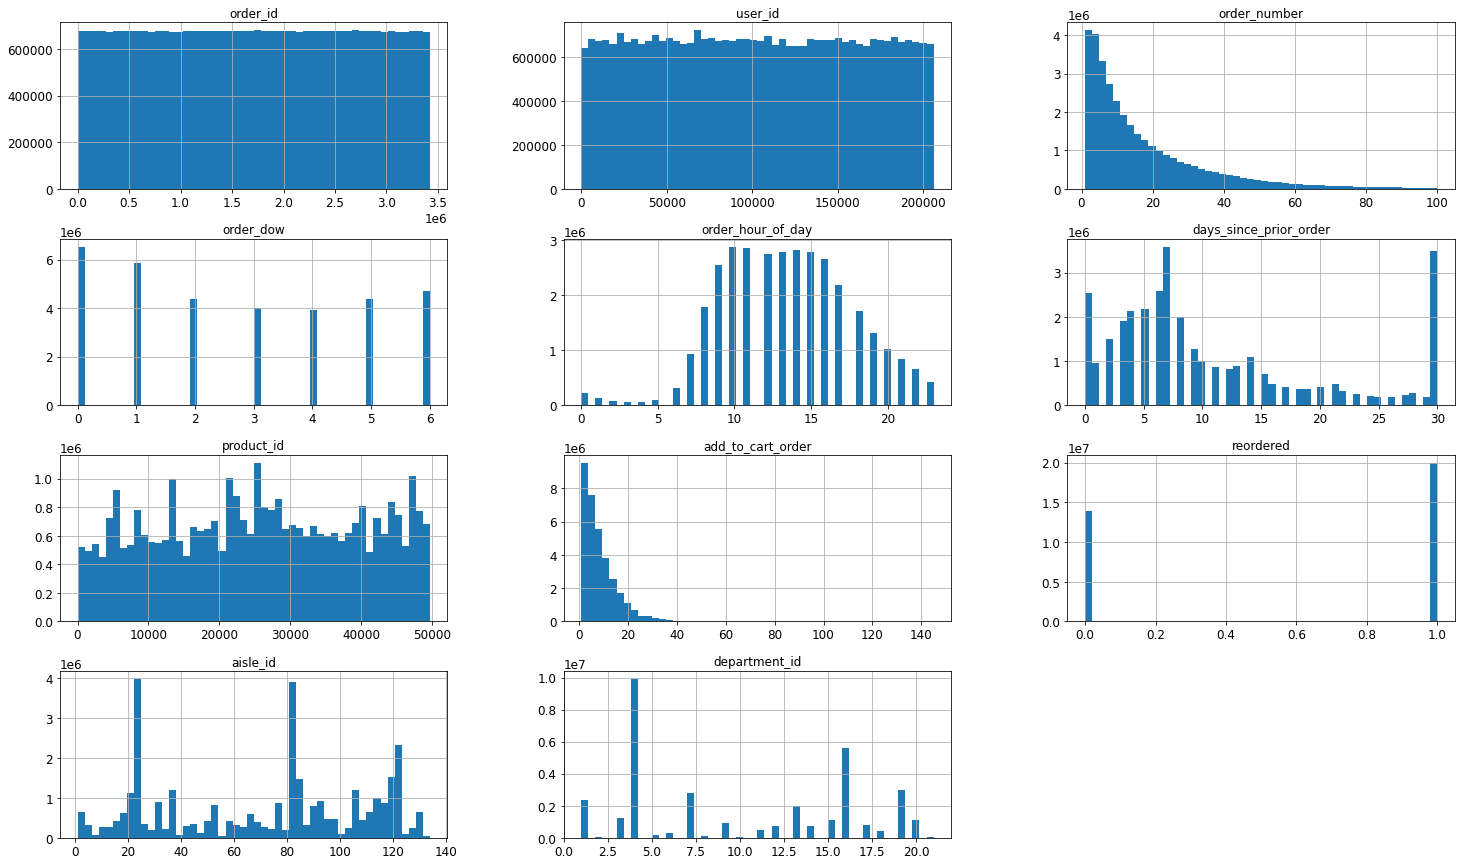

In [ ]:
# Plot all feature columns

df_full.hist(bins=50)
plt.show()

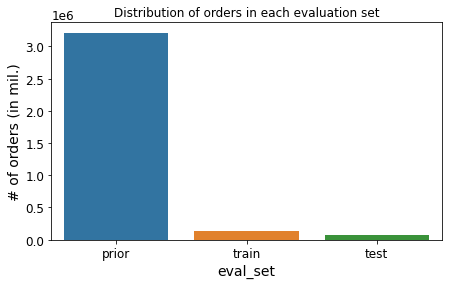

In [ ]:
# Check how many orders in each evaluation set

plt.figure(figsize=(7,4))
sns.countplot(x='eval_set', data=orders)
plt.title('Distribution of orders in each evaluation set')
plt.ylabel('# of orders (in mil.)')
plt.show()

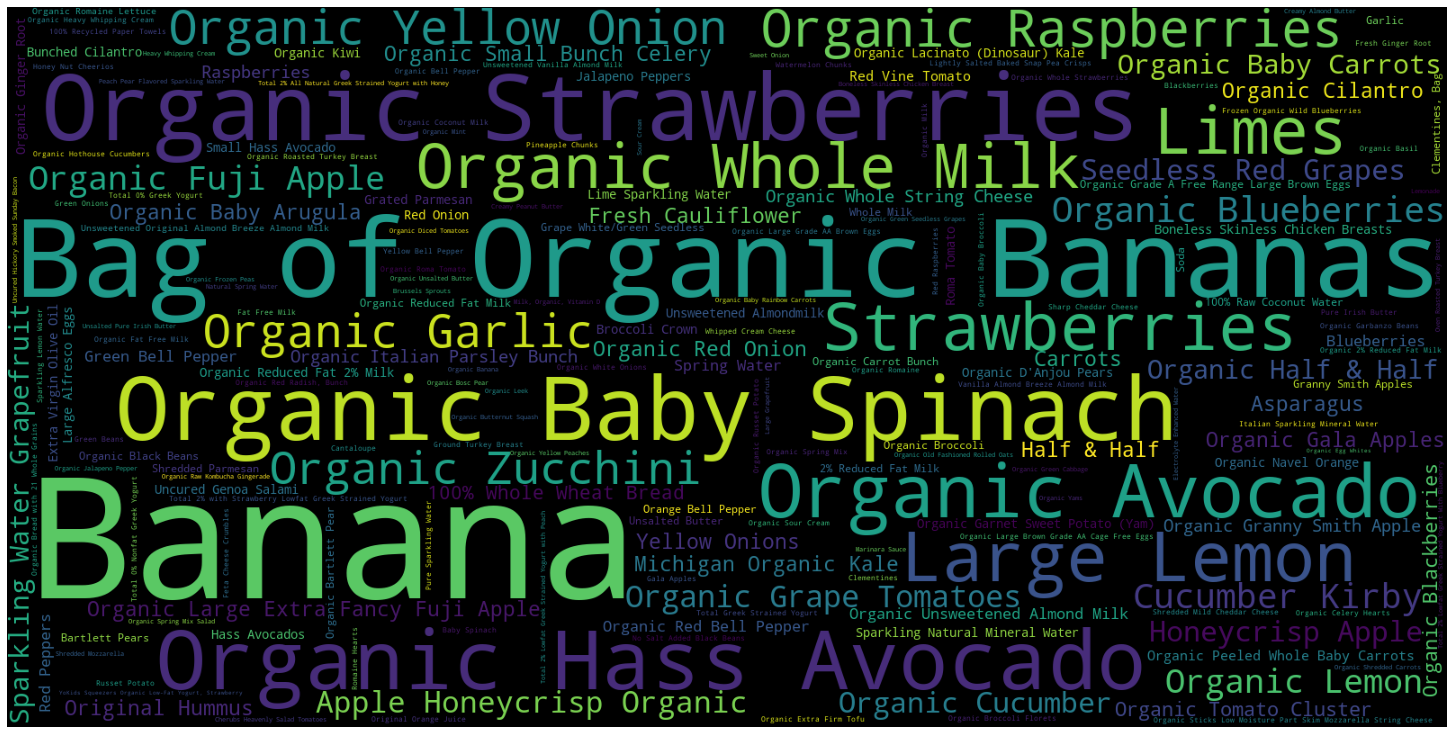

In [ ]:
# Ploting a word cloud to see which product names appear the most

p_name = df_full.product_name.value_counts().to_dict()
tup = dict(p_name.items())    

wc = WordCloud(background_color='black', width=1600, height=800,)
wc.generate_from_frequencies(tup)
plt.figure(figsize=(20,20))
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

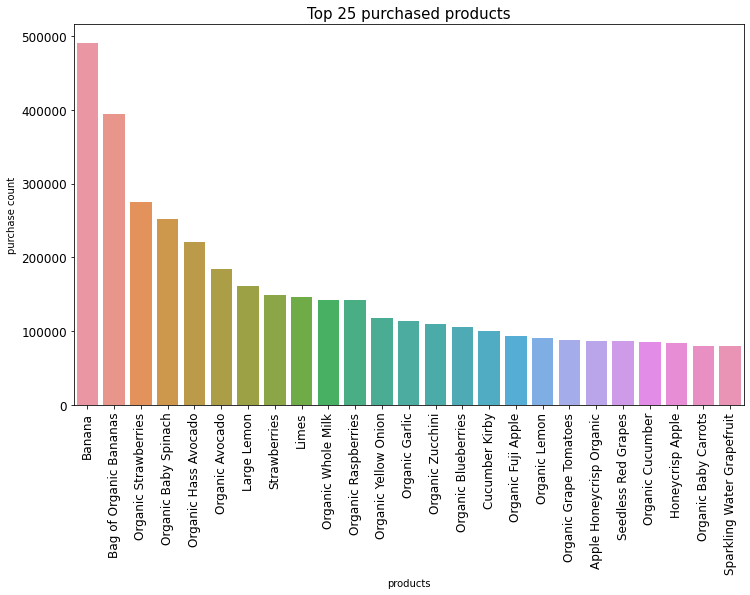

In [ ]:
# Plot the top 25 purchased products

top_prod = df_full.product_name.value_counts().head(25)
i=np.arange(25)
plt.figure(figsize=(12,7))
sns.barplot(top_prod.head(25).index, top_prod.head(25).values)
plt.title('Top 25 purchased products',fontsize=15)
plt.xticks(i, top_prod.reset_index().iloc[:,0], rotation='vertical')
plt.xlabel('products', fontsize=10)
plt.ylabel('purchase count', fontsize=10)
plt.show()

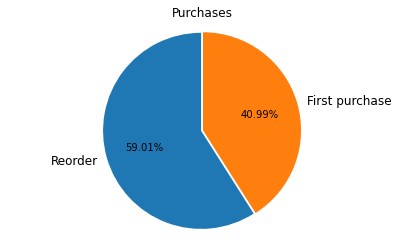

In [ ]:
# Check how many products are first purchase and reordered

labels = {0:'First purchase', 1:'Reorder'}
unique = df['reordered'].value_counts().rename(index=labels)

plt.figure(figsize=(7,4))
plt.pie(unique, explode=[0.01]*len(unique), labels=unique.index, startangle=90, autopct='%1.2f%%')
plt.axis('equal')
plt.title('Purchases')
plt.show()

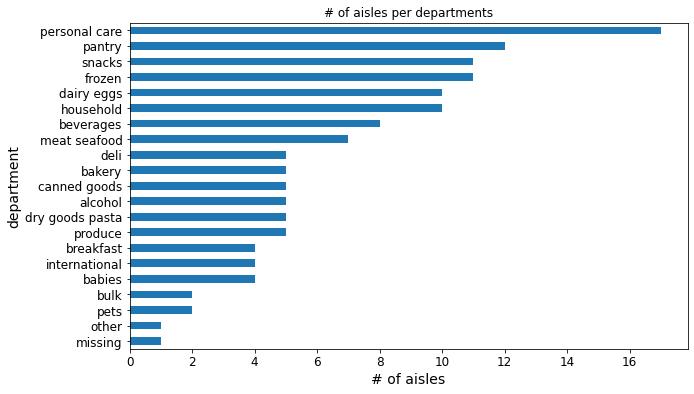

In [ ]:
# Check how many aisles per departments

dep_info = df_products.drop_duplicates(['department_id','aisle_id'],ignore_index=True)
dep_info = dep_info.groupby(['department'])['aisle_id'].count().sort_values()
dep_info.plot(kind='barh', figsize=(10,6))
plt.xlabel('# of aisles')
plt.title('# of aisles per departments')
plt.show()

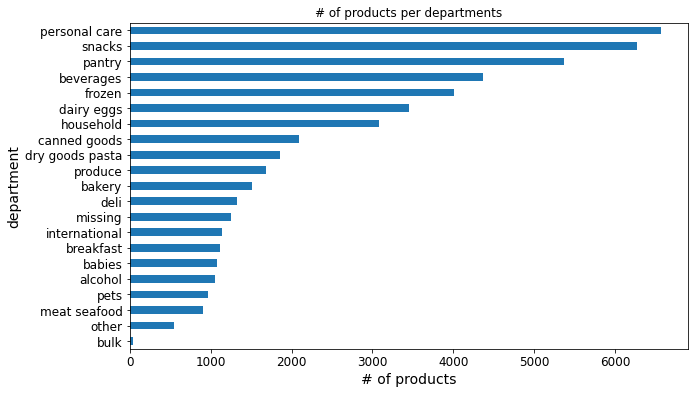

In [ ]:
# Check how many products per departments

prod_dep = df_products.groupby(['department'])['product_id'].count()
prod_dep.sort_values().plot(kind='barh', figsize=(10,6))
plt.xlabel('# of products')
plt.title('# of products per departments');

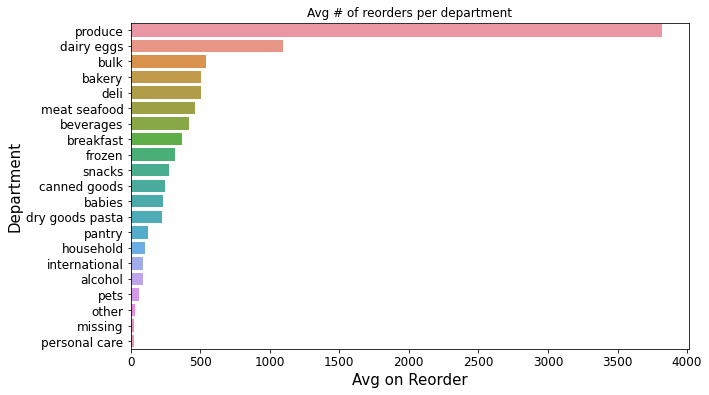

In [ ]:
# Check recorder per departments

reorder_dep = df_full.groupby(['department_id','department','product_id'], as_index=False)['reordered'].sum()
reorder_dep = reorder_dep.groupby(['department_id','department'], as_index=False).agg({'reordered':'mean'})
plt.figure(figsize=(10,6))
sns.barplot(data=reorder_dep.sort_values(['reordered'],ascending=False), x='reordered', y='department')
plt.xlabel('Avg on Reorder', fontsize=15)
plt.ylabel('Department', fontsize=15)
plt.title('Avg # of reorders per department')
plt.show()

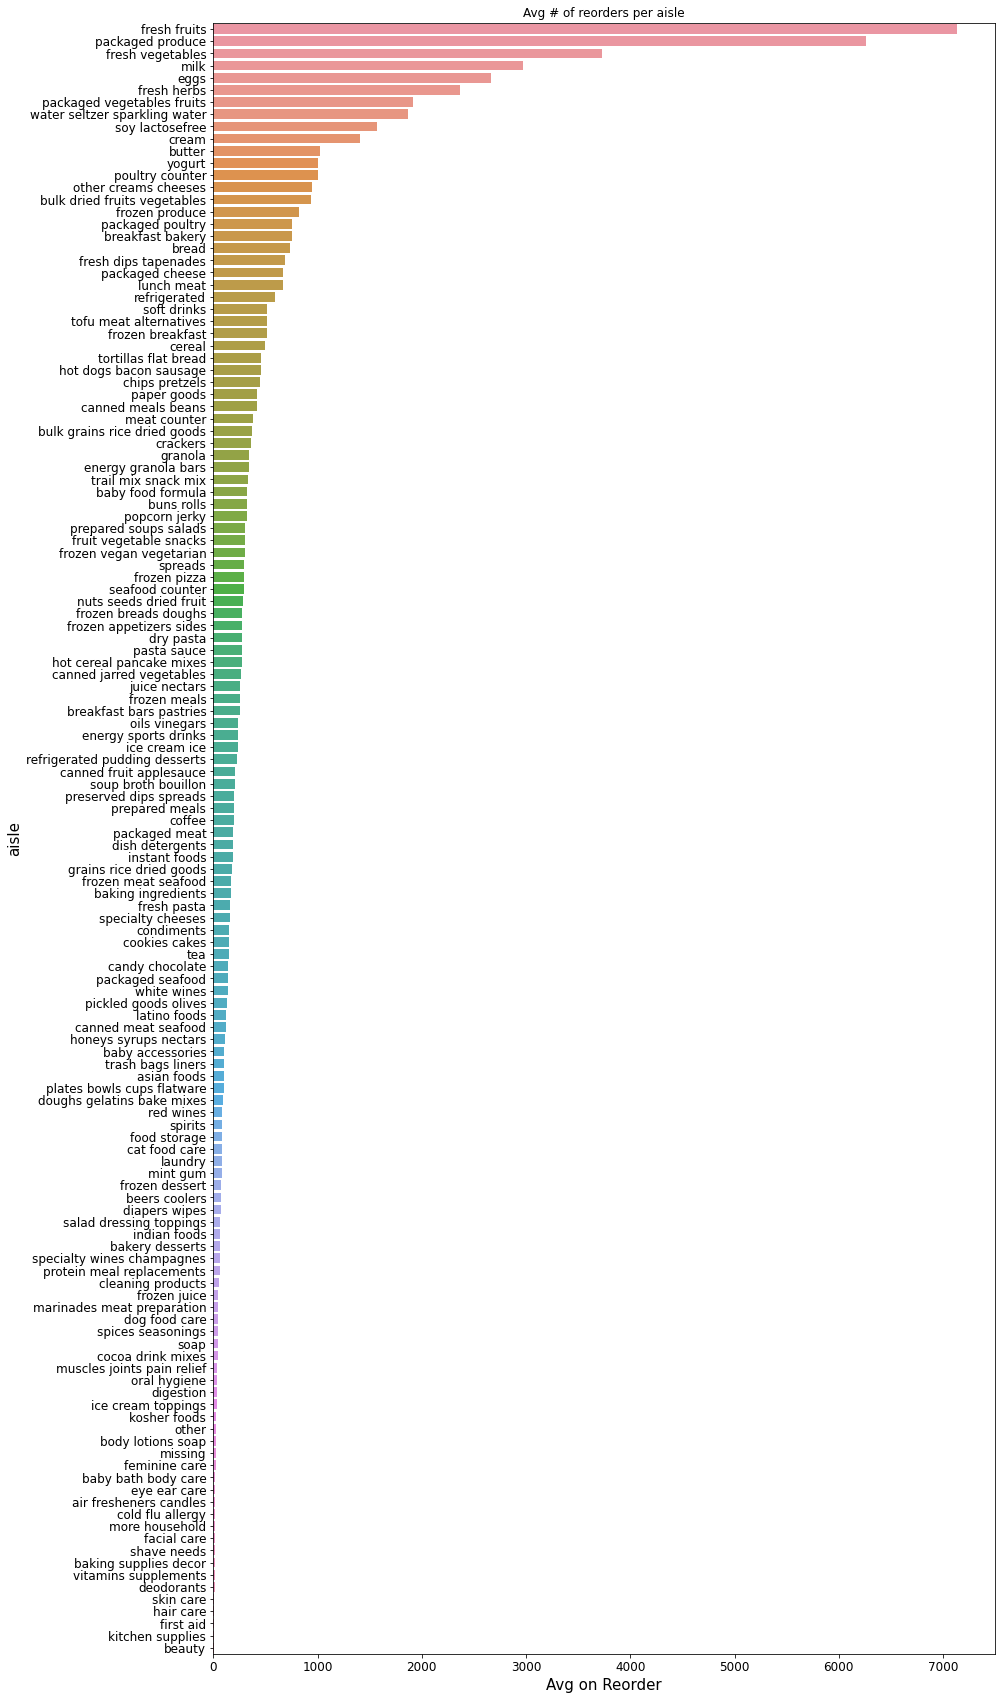

In [ ]:
# Check recorder per departments

reorder_aisle = df_full.groupby(['aisle_id','aisle','product_id'], as_index=False)['reordered'].sum()
reorder_aisle = reorder_aisle.groupby(['aisle_id','aisle'], as_index=False).agg({'reordered':'mean'})
plt.figure(figsize=(14,30))
sns.barplot(data=reorder_aisle.sort_values(['reordered'],ascending=False), x='reordered', y='aisle')
plt.xlabel('Avg on Reorder', fontsize=15)
plt.ylabel('aisle', fontsize=15)
plt.title('Avg # of reorders per aisle')
plt.show()

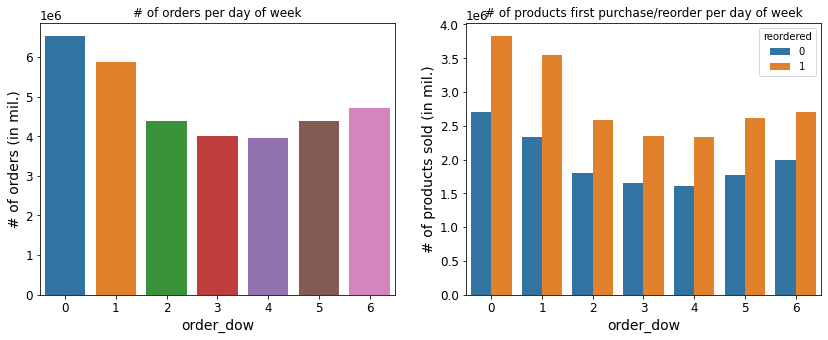

In [ ]:
# Check # of orders were placed over the week

plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
sns.countplot(x='order_dow', data=df)
plt.ylabel('# of orders (in mil.)')
plt.title('# of orders per day of week')

plt.subplot(1, 2, 2)
sns.countplot(x='order_dow',hue='reordered', data=df)
plt.ylabel('# of products sold (in mil.)')
plt.title('# of products first purchase/reorder per day of week')

plt.show()

### Model

#### Take subset for test analysis 

In [ ]:
# take random subset 
    
N = 100000
df_mod_subset = df.sample(N)
df_mod_subset

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered,aisle_id,department_id
12268488,74487,2,2,13,18.0,11078,0,131,9
16545614,100390,7,3,8,30.0,5077,1,112,3
3892738,23713,20,1,9,14.0,3651,1,53,16
27584778,168173,26,5,15,7.0,19051,0,107,19
25993954,158302,9,0,10,1.0,23011,1,43,3
...,...,...,...,...,...,...,...,...,...
31514562,192047,41,6,13,0.0,39928,1,24,4
19164262,116340,16,4,11,2.0,30756,0,24,4
2127395,13097,30,1,8,11.0,46206,1,24,4
24297036,147963,19,0,15,10.0,27086,1,53,16


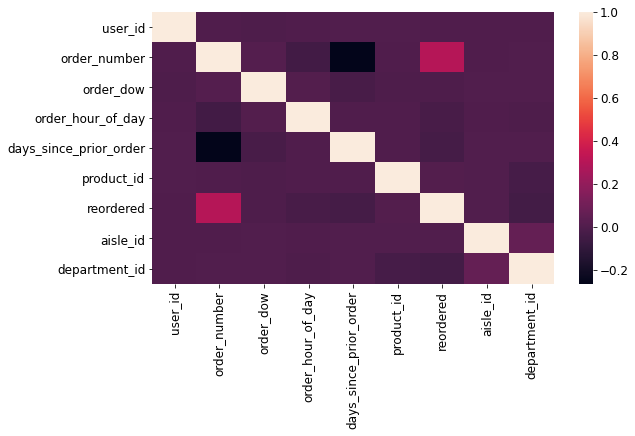

In [ ]:
corrMatrix = df_mod_subset.corr()
plt.figure(figsize=(9,5))
sns.heatmap(corrMatrix)
plt.show()

#### Sorting variables

In [ ]:
target = ['reordered']
predictors = [p for p in df_mod_subset.columns if p not in target]
categorical = ['aisle_id','department_id']
numerical = [c for c in df_mod_subset.columns if c not in (target + categorical)]

print('target: {}'.format(target))
print('predictors: {}'.format(predictors))
print('categorical: {}'.format(categorical))
print('numerical: {}'.format(numerical))    

target: ['reordered']
predictors: ['user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_id', 'aisle_id', 'department_id']
categorical: ['aisle_id', 'department_id']
numerical: ['user_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_id']


#### Spliting subset data into train and test

In [ ]:
X = df_mod_subset[predictors]
y = df_mod_subset[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (80000, 8)
X_test shape: (20000, 8)
y_train shape: (80000, 1)
y_test shape: (20000, 1)


#### Defining and apply pipeline

In [ ]:
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown = "ignore")),
])

num_pipeline = Pipeline([
    ('mmscaler', MinMaxScaler()),
])

full_pipeline = ColumnTransformer([
    ('cat', cat_pipeline, categorical),
    ('num', num_pipeline, numerical),
])


full_pipeline.fit(X_train)
X_train_transformed = full_pipeline.transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)

print('X_train_transformed shape: {}'.format(X_train_transformed.shape))
print('X_test_transformed shape: {}'.format(X_test_transformed.shape))

X_train_transformed shape: (80000, 161)
X_test_transformed shape: (20000, 161)


In [ ]:
# This is no longer required after moved Product_Id to numerical feature
# Performing dimensionality reduction of features using TruncatedSVD. I was using PCA originally, however it does not support sparse matrix.

# from sklearn.decomposition import PCA, TruncatedSVD

# svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)

# X_train_svd = svd.fit_transform(X_train_transformed)
# X_test_svd = svd.transform(X_test_transformed)

# print('X_train_svd shape: {}'.format(X_train_svd.shape))
# print('X_test_svd shape: {}'.format(X_test_svd.shape))

#### Build Random Forest Classifier

In [ ]:
time_start = time.time()

param_dist = {
    'n_estimators': [10,100,200],
    'max_features': [0.1,0.5],
    'criterion': ['gini', 'entropy'], 
    'max_depth': [1,10,50], 
    'min_samples_split': [1,10,20], 
    'max_leaf_nodes': [2,10,100],
}

rf_clf = RandomForestClassifier(random_state = 123)

rf_grid_cv = GridSearchCV(rf_clf, param_dist, cv=5, scoring='roc_auc', n_jobs=-1)
rf_grid_cv.fit(X_train_transformed, np.ravel(y_train))

print('Tuned parameters are: \n{}'.format(rf_grid_cv.best_params_))
print()
print('Best score is: \n{}'.format(rf_grid_cv.best_score_))
print()
print('Random Forest Classifier done! Time elapsed: {} seconds'.format(time.time()-time_start))

Tuned parameters are: 
{'criterion': 'entropy', 'max_depth': 50, 'max_features': 0.5, 'max_leaf_nodes': 100, 'min_samples_split': 10, 'n_estimators': 200}

Best score is: 
0.7728350377931095

Random Forest Classifier done! Time elapsed: 1460.401905298233 seconds


In [ ]:
rfc_model = rf_grid_cv.best_estimator_
rf_y_pred = rfc_model.predict(X_test_transformed)
rf_y_pred_prob = rfc_model.predict_proba(X_test_transformed)
print('Confusion matrix: \n', confusion_matrix(y_test, rf_y_pred))
print()
print('Classification report: \n', classification_report(y_test, rf_y_pred))
print()
print('Prediction Accuracy Score:', accuracy_score(np.ravel(y_test), rf_y_pred))
print('Prediction F1 Score:', f1_score(np.ravel(y_test), rf_y_pred))
print('Prediction ROC_AUC_Score:', roc_auc_score(y_test, rf_y_pred_prob[:,1]))

Confusion matrix: 
 [[ 4239  3943]
 [ 1676 10142]]

Classification report: 
               precision    recall  f1-score   support

           0       0.72      0.52      0.60      8182
           1       0.72      0.86      0.78     11818

    accuracy                           0.72     20000
   macro avg       0.72      0.69      0.69     20000
weighted avg       0.72      0.72      0.71     20000


Prediction Accuracy Score: 0.71905
Prediction F1 Score: 0.7830753194610663
Prediction ROC_AUC_Score: 0.7743872022753304


In [ ]:
# Feature Importance

rf_feat = Pipeline(steps=[('preprocessor', full_pipeline), ('classifier', rfc_model)])

onehot_columns = list(rf_feat.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical))
numeric_features_list = list(numerical)
numeric_features_list.extend(onehot_columns)

eli5.explain_weights(rf_feat.named_steps['classifier'], top=30, feature_names=numeric_features_list, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.6504 ± 0.2534,department_id_17
0.1372 ± 0.2459,department_id_20
0.0506 ± 0.0174,department_id_7
0.0299 ± 0.0183,aisle_id_18
0.0172 ± 0.0140,department_id_10
0.0141 ± 0.0060,department_id_5
0.0112 ± 0.0092,aisle_id_78
0.0102 ± 0.0083,department_id_21
0.0086 ± 0.0152,aisle_id_132
0.0079 ± 0.0055,department_id_11


#### Build ADA Boost Classifier

In [ ]:
time_start = time.time()

param_dist = {
    'n_estimators': [5, 10, 15, 20],
    'learning_rate': [0.01,0.05,0.1,0.5,1],
    'algorithm': ['SAMME', 'SAMME.R'],
}

ada_clf = AdaBoostClassifier(random_state = 123)

ada_grid_cv = GridSearchCV(ada_clf, param_dist, cv = 5, scoring='roc_auc', refit = True, n_jobs = -1)
ada_grid_cv.fit(X_train_transformed, np.ravel(y_train))

print('Tuned parameters are: \n{}'.format(ada_grid_cv.best_params_))
print()
print('Best score is: \n{}'.format(ada_grid_cv.best_score_))
print()
print('ADA Boost Classifier done! Time elapsed: {} seconds'.format(time.time()-time_start))

Tuned parameters are: 
{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 20}

Best score is: 
0.7646917251759706

ADA Boost Classifier done! Time elapsed: 35.30193781852722 seconds


In [ ]:
ada_model = ada_grid_cv.best_estimator_
ada_y_pred = ada_model.predict(X_test_transformed)
ada_y_pred_prob = ada_model.predict_proba(X_test_transformed)
print('Confusion matrix: \n', confusion_matrix(y_test, ada_y_pred))
print()
print('Classification report: \n', classification_report(y_test, ada_y_pred))
print()
print('Prediction Accuracy Score:', accuracy_score(np.ravel(y_test), ada_y_pred))
print('Prediction F1 Score:', f1_score(np.ravel(y_test), ada_y_pred))
print('Prediction ROC_AUC_Score:', roc_auc_score(y_test, ada_y_pred_prob[:,1]))

Confusion matrix: 
 [[ 4296  3886]
 [ 1771 10047]]

Classification report: 
               precision    recall  f1-score   support

           0       0.71      0.53      0.60      8182
           1       0.72      0.85      0.78     11818

    accuracy                           0.72     20000
   macro avg       0.71      0.69      0.69     20000
weighted avg       0.72      0.72      0.71     20000


Prediction Accuracy Score: 0.71715
Prediction F1 Score: 0.7803192109044309
Prediction ROC_AUC_Score: 0.7668929478745079


In [ ]:
# Feature Importance

ada_feat = Pipeline(steps=[('preprocessor', full_pipeline), ('classifier', ada_model)])

onehot_columns = list(ada_feat.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical))
numeric_features_list = list(numerical)
numeric_features_list.extend(onehot_columns)

eli5.explain_weights(ada_feat.named_steps['classifier'], top=30, feature_names=numeric_features_list, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.4000 ± 0.9798,department_id_17
0.1000 ± 0.6000,department_id_20
0.0500 ± 0.4359,aisle_id_109
0.0500 ± 0.4359,department_id_7
0.0500 ± 0.4359,department_id_5
0.0500 ± 0.4359,department_id_11
0.0500 ± 0.4359,department_id_3
0.0500 ± 0.4359,aisle_id_78
0.0500 ± 0.4359,department_id_9
0.0500 ± 0.4359,aisle_id_18


#### Build LightGBM Classifier

In [ ]:
time_start = time.time()

param_dist = {
    'learning_rate':[0.05,0.1,0.15,0.2],
     'n_estimators':[50,100,150,200,300],
     'max_depth':[3,5,8,10],
     'num_leaves':[31,62,93],
     'class_weight':[{0:1,1:5},{0:1,1:10},{0:1,1:50}],
}

lgbm_clf = LGBMClassifier(device_type='gpu', random_state = 123)

lgbm_grid_cv = RandomizedSearchCV(lgbm_clf, param_dist, cv=5, scoring='roc_auc', n_jobs = -1)
lgbm_grid_cv.fit(X_train_transformed, np.ravel(y_train))

print('Tuned parameters are: \n{}'.format(lgbm_grid_cv.best_params_))
print()
print('Best score is: \n{}'.format(lgbm_grid_cv.best_score_))
print()
print('LightGBM Classifier done! Time elapsed: {} seconds'.format(time.time()-time_start))

Tuned parameters are: 
{'num_leaves': 62, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.15, 'class_weight': {0: 1, 1: 5}}

Best score is: 
0.7789756287556626

LightGBM Classifier done! Time elapsed: 41.877071142196655 seconds


In [ ]:
lgbm_model = lgbm_grid_cv.best_estimator_
lgbm_y_pred = lgbm_model.predict(X_test_transformed)
lgbm_y_pred_prob = lgbm_model.predict_proba(X_test_transformed)
print('Confusion matrix: \n', confusion_matrix(y_test, lgbm_y_pred))
print()
print('Classification report: \n', classification_report(y_test, lgbm_y_pred))
print()
print('Prediction Accuracy Score:', accuracy_score(np.ravel(y_test), lgbm_y_pred))
print('Prediction F1 Score:', f1_score(np.ravel(y_test), lgbm_y_pred))
print('Prediction ROC_AUC_Score:', roc_auc_score(y_test, lgbm_y_pred_prob[:,1]))

Confusion matrix: 
 [[ 1588  6594]
 [   52 11766]]

Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.19      0.32      8182
           1       0.64      1.00      0.78     11818

    accuracy                           0.67     20000
   macro avg       0.80      0.59      0.55     20000
weighted avg       0.77      0.67      0.59     20000


Prediction Accuracy Score: 0.6677
Prediction F1 Score: 0.7797733448207304
Prediction ROC_AUC_Score: 0.7805127130004283


In [ ]:
# Feature Importance

lgbm_feat = Pipeline(steps=[('preprocessor', full_pipeline), ('classifier', lgbm_model)])

onehot_columns = list(lgbm_feat.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical))
numeric_features_list = list(numerical)
numeric_features_list.extend(onehot_columns)

eli5.show_weights(lgbm_feat.named_steps['classifier'], top=30, feature_names=numeric_features_list, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.7428,department_id_17
0.0393,department_id_7
0.0288,department_id_20
0.0270,department_id_21
0.0181,aisle_id_18
0.0149,department_id_16
0.0123,department_id_5
0.0119,department_id_10
0.0079,aisle_id_78
0.0078,department_id_19


In [ ]:
# All 3 models feature importance show department_id_17

departments.loc[departments['department_id'] == 17]

,department_id,department
16,17,household


#### Plot ROC Curve

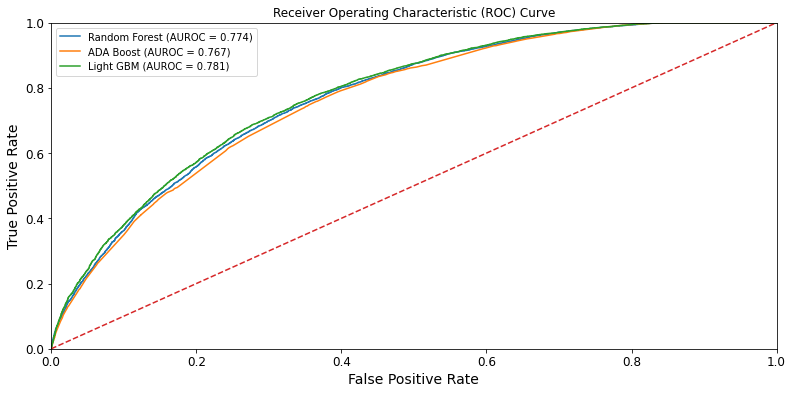

In [ ]:
from sklearn.metrics import roc_curve

rf_auc = roc_auc_score(y_test, rf_y_pred_prob[:,1])
ada_auc = roc_auc_score(y_test, ada_y_pred_prob[:,1])
lgbm_auc = roc_auc_score(y_test, lgbm_y_pred_prob[:,1])

rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_y_pred_prob[:,1])
ada_fpr, ada_tpr, ada_thresholds = roc_curve(y_test, ada_y_pred_prob[:,1])
lgbm_fpr, lgbm_tpr, lgbm_thresholds = roc_curve(y_test, lgbm_y_pred_prob[:,1])

plt.figure(figsize=(13,6))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(ada_fpr, ada_tpr, label='ADA Boost (AUROC = %0.3f)' % ada_auc)
plt.plot(lgbm_fpr, lgbm_tpr, label='Light GBM (AUROC = %0.3f)' % lgbm_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.axis([0, 1, 0, 1]) 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#### Plot Learning Curve

In [ ]:
def plot_learning_curve(estimator, train_sizes, train_scores, test_scores):
    # Calculate training and test mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, color='red', marker='o', markersize=5, label='Training score')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='red')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Cross-validation score')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title('Learning Curve for {}'.format(estimator))
    plt.xlabel('Training Data Size')
    plt.ylabel('Model accuracy')
    plt.grid()
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
# transform whole dataset for plotting learning curve

full_pipeline.fit(X)
X_transformed = full_pipeline.transform(X)

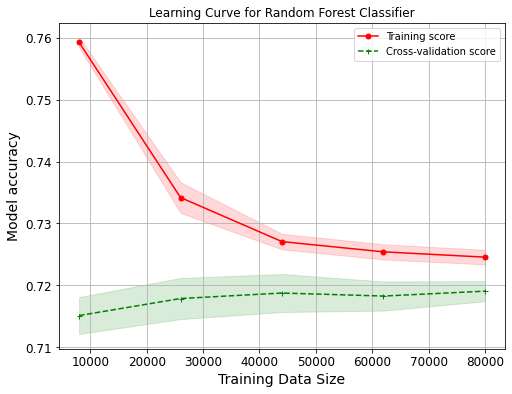

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(rfc_model, X_transformed, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=5, scoring='accuracy', n_jobs=-1)

plot_learning_curve('Random Forest Classifier', train_sizes, train_scores, test_scores)

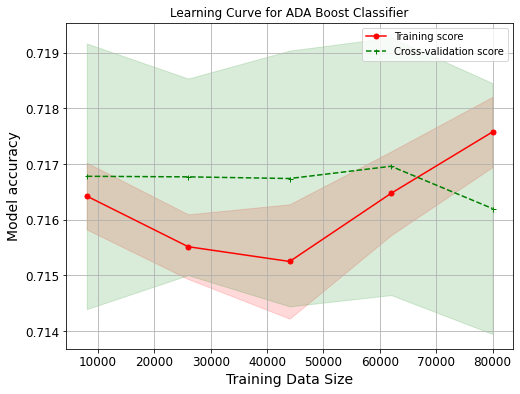

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(ada_model, X_transformed, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=5, scoring='accuracy', n_jobs=-1)

plot_learning_curve('ADA Boost Classifier', train_sizes, train_scores, test_scores)

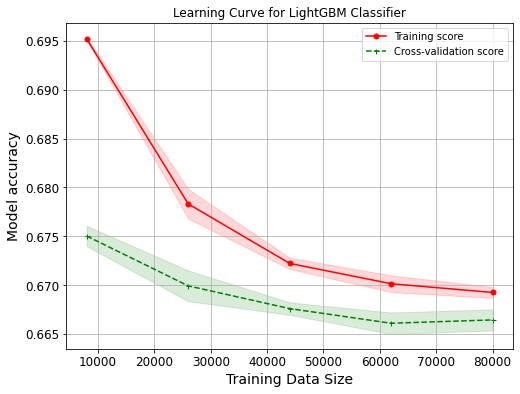

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(lgbm_model, X_transformed, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=5, scoring='accuracy', n_jobs=-1)

plot_learning_curve('LightGBM Classifier', train_sizes, train_scores, test_scores)